# Memology - DataScience & Memes
![](http://orig07.deviantart.net/3e62/f/2015/267/4/1/meme_team_logo_png_smol_by_kuiwi-d9ass0h.png)

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json

from sklearn.learning_curve import validation_curve,learning_curve
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

###  Part 1. Dataset and features description 

**TL;DR about the project**

I have collected (parsed) data from [knowyourmeme.com](http://knowyourmeme.com/) about 11679 memes, carefully placed on 369 pages. My crawling from page to page automatically was not really the best looking idea from a server point of view, so I got banned by IP. To avoid misunderstandings between my parser and server I had to search far and wide for the methods to bypass the security. As a result I came across TOR which dinamically updates the IP address for every new request and which I managed to connect to with Python. You may find more about parser in the [repository](https://github.com/DmitrySerg/memology)

The project itself is dedicated to the greatest achievement of humanity - memes. I will try to forecast the popularity of a meme based on its text description.

In [5]:
memes = pd.read_csv('/Users/dmitrys/Desktop/DataProjects/KnowYourMemes/all_data_memes.csv')

In [6]:
memes.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [7]:
memes = memes.drop_duplicates("name") # some memes were in duplicate due to the site structure

In [8]:
memes.reset_index(drop=True, inplace=True)

In [9]:
memes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11679 entries, 0 to 11678
Data columns (total 10 columns):
name        11679 non-null object
added       11679 non-null object
views       11679 non-null int64
comments    11679 non-null object
status      11679 non-null object
year        11679 non-null object
tags        11679 non-null object
about       6832 non-null object
origin      4819 non-null object
spread      947 non-null object
dtypes: int64(1), object(9)
memory usage: 912.5+ KB


Great, let's have a look at variables:

- name - the name of the meme
- added - date when it was added to the site
- views - amount of views on the site 
- comments - amount of comments on the site
- status - categorical variable, status is given to a meme depending on the 'approval' of one by the community 
- year - year of the first appearance of the origin
- tags - tags given to meme
- about - text description 
- origin - description of the origin 
- spread - where has it spread 

In [10]:
memes.head(3)

,name,added,views,comments,status,year,tags,about,origin,spread
0,Last Time The Cubs Won the World Series,"Nov 03, 2016 at 11:22AM EDT",17157,60,Submission,Sports,Chicago,Last Time the Cubs Won the World Series refers...,NaN,Jokes and fascination with the Cubs’ had small...
1,PenorCut's Fiverr Videos,"Jul 20, 2015 at 07:54PM EDT",36629,39,Submission,Researching,YouTube,NaN,NaN,NaN
2,AmourShipping,"Nov 02, 2016 at 03:01PM EDT",32293,81,Submission,Pairing,Unknown,Amourshipping refers to the romantic pairing o...,"On September 12th, 2013, a discussion thread f...",NaN


In [11]:
memes.tail(3)

,name,added,views,comments,status,year,tags,about,origin,spread
11676,Cannon Penis,"Oct 11, 2010 at 06:07PM EDT",20202,14,Submission,NSFW,YouTube,NaN,NaN,NaN
11677,Gaben,"Oct 11, 2010 at 01:22PM EDT",479780,49,Submission,2010,"tf2, stop, newell, control, wait, gabe, gaben,...","Gaben is a nickname given to Gabe Newell, the ...",The soundclip of Gabe Newell saying “gaben” ca...,NaN
11678,alex smith fail,"Oct 11, 2010 at 06:00AM EDT",2730,14,Deadpool,2010,"alex smith, 49ers, sf, san francisco, fail.qb,...",NaN,NaN,NaN


###  Part  2. Data exploration

The first thing to do, of course, is to find the most popular meme of all times

In [12]:
memes[memes.views==memes.views.max()]

,name,added,views,comments,status,year,tags,about,origin,spread
5408,Doge,"Jul 24, 2013 at 04:29PM EDT",11551088,893,Confirmed,Character,Tumblr,Doge is a slang term for “dog” that is primari...,The use of the misspelled word “doge” to refer...,"On October 28th, 2010, a photo of Kabosu was s..."


And this is Doge!

![](http://i0.kym-cdn.com/entries/icons/original/000/013/564/doge.jpg)

# Date added

Since we are having a great variable `added`, it would be great to play with it a little, transform into datetime format and get hour, weekday, month and year out of it

In [13]:
memes['Timestamp'] = memes.added.apply(lambda x: pd.to_datetime(x))
memes['Year'] = memes.Timestamp.apply(lambda x: x.year)
memes['Month'] = memes.Timestamp.apply(lambda x: x.month)
memes['Day'] = memes.Timestamp.apply(lambda x: x.day)
memes['Hour'] = memes.Timestamp.apply(lambda x: x.hour)
memes['Weekday'] = memes.Timestamp.apply(lambda x: x.weekday())

I will also need a variable accounting for the amount of days passed since the addition to the site

In [14]:
memes['days_from_creation'] = (memes.Timestamp.max() - memes.Timestamp)/np.timedelta64(1, 'D')

Now it's possible to plot some histograms for newly created variables

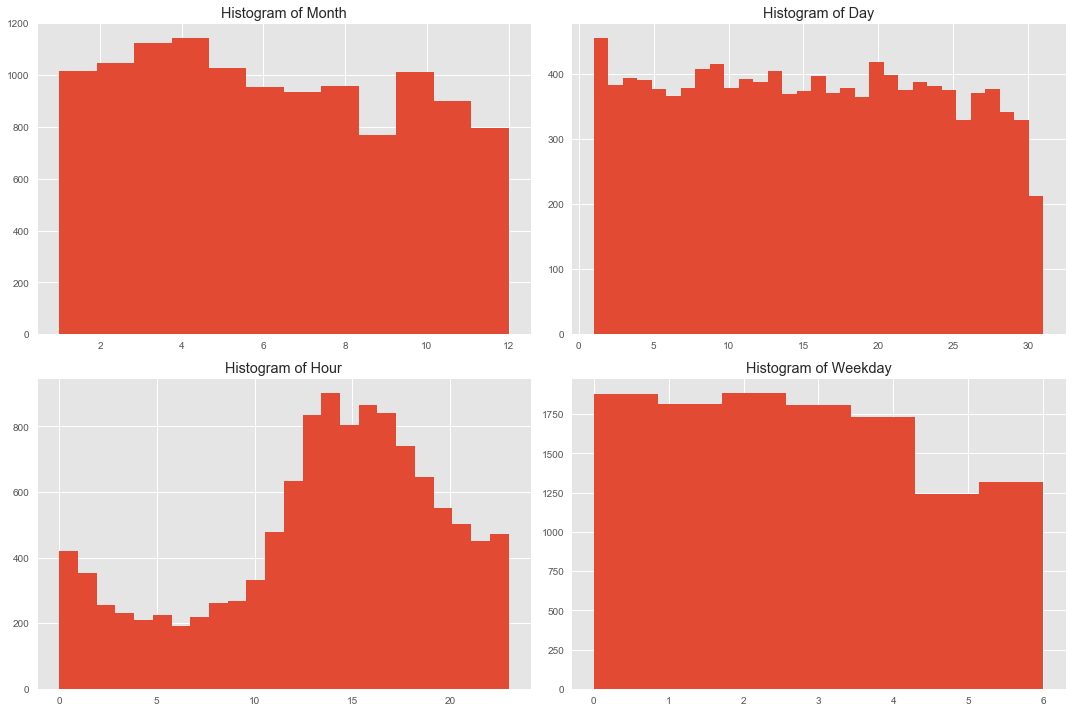

In [16]:
index =0 
f, axarr = plt.subplots(2, 2, figsize=(15,10))
times = ['Month', 'Day', 'Hour', 'Weekday']
bins = [12, 31, 24, 7]
index = 0
for i in range(2):
    for j in range(2):
        axarr[i, j].hist(memes[times[index]], bins = bins[index])
        axarr[i, j].set_title('Histogram of {}'.format(times[index]))
        index += 1

f.subplots_adjust(hspace=0.2)
f.tight_layout()

Oh boy what do we have here:
- We have a visible drop in September on the month histogram, (probably main audience of the site has classes starting in this month)
- Day has nothing special, the distribution is pretty much uniform
- Hour histogram is quite illustrative - during the night activity goes down and then grows, reaching its peak right after the school ends
- Weekday distribution shows a significant drop during weekends, I wonder why is that so

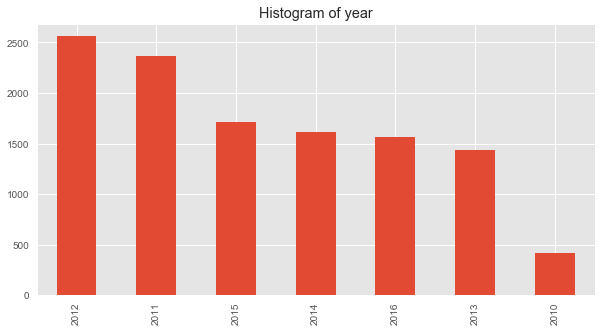

In [17]:
memes.Year.value_counts().plot(kind='bar', figsize=(10, 5))
plt.title("Histogram of year")
plt.show()

In [18]:
memes.Year.value_counts(normalize=True).apply(lambda x: "{}%".format(str(round(x, 3)*100)))

2012                  21.9%
2011                  20.3%
2015                  14.7%
2014    13.900000000000002%
2016                  13.4%
2013                  12.3%
2010    3.5999999999999996%
Name: Year, dtype: object

It seems like 2011 and 2012 were a golden era for memes, 42% (what a coincidence) of all memes on the site were added during these two years

# Year of the first appearance of the origin

Let's have a look at the second variable connected with year - year of the first meme appearance, `year`

In [19]:
memes.year.value_counts()[:10]

2011           1670
2012           1238
Unknown         881
2010            597
2013            581
NSFW            541
2014            529
2016            406
Researching     383
2015            343
Name: year, dtype: int64

Unfortunately, some tags found their way into this variable, we'll have to clean them, simultaneously adding those values to the `tag` variable

In [20]:
def clearYear(year):
    if not year.isdigit():
        return np.NaN, ' '+year
    else:
        return int(year), ''

In [21]:
years, tags = zip(*memes.year.apply(lambda x: clearYear(x)))
memes.year = years
memes.tags += tags

In [22]:
memes.tags[memes.tags.isin(['none...', 'none', 'Unknown', 'none... Unknown', 'None'])] = 'unknown'

In [23]:
memes.year.describe()

count    7218.000000
mean     2007.279163
std        40.585179
min      1000.000000
25%      2009.000000
50%      2011.000000
75%      2013.000000
max      2916.000000
Name: year, dtype: float64

Perfect! Now that the variable is clean, we can see that the minimal value is 1000 and maximum - 2196, which looks like a misprint of '2016'

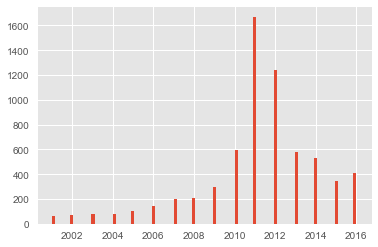

In [24]:
memes.year[(memes.year>2000)&(memes.year<2020)].hist(bins=100)
plt.show()

Adding some bounds for the plot allows us to prove once again that 2011 and 2012 were the origin years for most of memes

Now we can have a look at the most "historical" memes, that had their origin before, say, year 1500

In [34]:
ancient = memes[memes.year<1500]
ancient.dropna(subset=['about'], inplace=True)
for i in ancient.index.tolist():
    print("Name: {}".format(ancient.loc[i, "name"]))
    print("Year: {}".format(ancient.loc[i, "year"]))
    print("About:\n{}".format(ancient.loc[i, "about"]))
    print("==================================================================\n")

Name: Tutankhamun
Year: 1341.0
About:
Tutankhamun (lit. translation, Living Image of Amun) was an ancient Egyptian pharaoh who rose to power and control of Egypt at the age of 10 and ruled for approximately 8 years before his death in 1323 B.C. at the age of 18 or 19 years old. Because of this, as well as the circumstances surrounding the excavation of his tomb lead by Howard Carter in 1922, and what has been discovered since his tomb’s discovery, he has become famous around the world for being the subject of one of the world’s most in-depth excavations and ongoing archaeological mysteries.

Name: Foxes
Year: 1000.0
About:
Foxes are omnivorous members of the Canidae family, a lineage of carnivorous mammals that also includes dogs, wolves and jackals. Foxes are found on every continent except Antarctica, with the most common species being the red fox (Vulpes vulpes) and its 47 recognized sub-species.

Name: Katana
Year: 1392.0
About:
Katana are traditional Japanese swords originally wie

Neat, meme creators found inspiration in so many historical events and artifacts, even Vitruvian Man and The Last Supper have their own memes.

# Amount of views

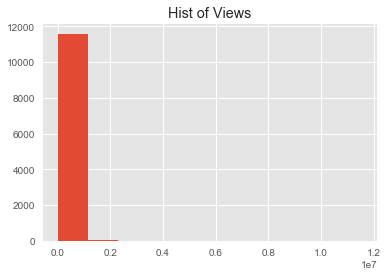

In [35]:
memes.views[memes.views>0].hist(bins=10)
plt.title("Hist of Views")
plt.show()

Skewed to the left, logarithm will cure that

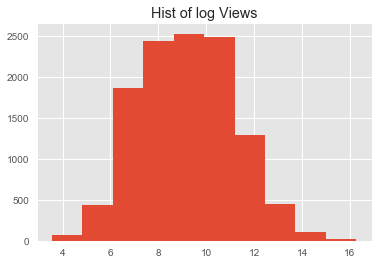

In [37]:
memes.views[memes.views>0].apply(np.log).hist(bins=10)
plt.title("Hist of log Views")
plt.show()

# Popularity

Metrics of popularity will be the estimated number of views per day. To calculate it, simply divide the amount of views by the days passed since publication

In [38]:
memes['average_views'] = memes.views/memes.days_from_creation

In [39]:
# most rescent meme, at the time of parsing the data exactly 0 days have passed 
# since its publication, so we'll have to clean it by replacing average with fact views
memes.average_views[memes.name=="#DrunkHillary"] = 2568 

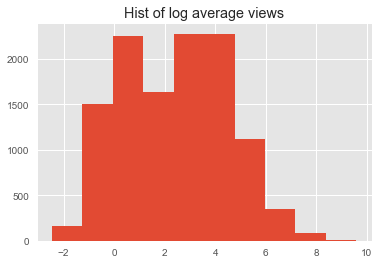

In [40]:
plt.hist(memes.average_views.apply(np.log))
plt.title("Hist of log average views");

### Let's have a look at the most popular!

In [41]:
popular = memes.sort_values(by='average_views', ascending=False)
for i in popular.index.tolist()[:7]:
    print('Meme name: ')
    print(popular.loc[i,'name'])
    print("Average views (per day) {}".format(round(popular.loc[i,'average_views'])))
    print('==============\n')

Meme name: 
Harambe the Gorilla
Average views (per day) 14441.0

Meme name: 
Dat Boi
Average views (per day) 13750.0

Meme name: 
Ken Bone
Average views (per day) 11085.0

Meme name: 
Doge
Average views (per day) 9611.0

Meme name: 
Describe Yourself in 3 Fictional Characters
Average views (per day) 7528.0

Meme name: 
Hugh Mungus
Average views (per day) 6872.0

Meme name: 
( ͡° ͜ʖ ͡°) / Lenny Face
Average views (per day) 6747.0



[Harambe](http://knowyourmeme.com/memes/harambe-the-gorilla) is in the lead - damn ninjas were cutting their onions too fast. Doge is among the top as well!

# Comments

In [42]:
memes.comments[~memes.comments.apply(lambda x: x.isdigit())][:10]

9      1 Comment">\n<a href="/memes/sombra#comments" ...
10     1 Comment">\n<a href="/memes/subcultures/pokem...
36     1 Comment">\n<a href="/memes/cajama#comments" ...
56     1 Comment">\n<a href="/memes/spinnyboiz#commen...
65     1 Comment">\n<a href="/memes/finally-i-can-exp...
71     1 Comment">\n<a href="/memes/mr-hudson#comment...
117    1 Comment">\n<a href="/memes/wallace-and-gromi...
118    1 Comment">\n<a href="/memes/worm-on-a-string#...
120    1 Comment">\n<a href="/memes/slondermon#commen...
122    1 Comment">\n<a href="/memes/harambe-s-son-and...
Name: comments, dtype: object

Needs some cleaning again - some HTML tags are still present 

In [43]:
memes.comments[~memes.comments.apply(lambda x: x.isdigit())] = 1
memes.comments = memes.comments.astype(int)

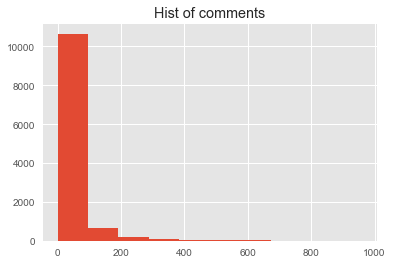

In [44]:
memes.comments.hist()
plt.title("Hist of comments")
plt.show()

### How about most commented memes

In [45]:
memes['average_comments'] = memes.comments/memes.days_from_creation

In [46]:
memes.average_comments[memes.name == "#DrunkHillary"] = memes.comments[memes.name == "#DrunkHillary"]

In [47]:
popular = memes.sort_values(by='average_comments', ascending=False)
for i in popular.index.tolist()[:7]:
    print('Meme name: ')
    print(popular.loc[i,'name'])
    print("Average comments (per day) {}".format(round(popular.loc[i,'average_comments'])))
    print('==============\n')

Meme name: 
#SpiritCooking
Average comments (per day) 50.0

Meme name: 
#DrunkHillary
Average comments (per day) 29.0

Meme name: 
AmourShipping
Average comments (per day) 16.0

Meme name: 
#ScienceMustFall
Average comments (per day) 16.0

Meme name: 
Last Time The Cubs Won the World Series
Average comments (per day) 15.0

Meme name: 
Vote From Home
Average comments (per day) 14.0

Meme name: 
"On November 9th..."
Average comments (per day) 12.0



# Status

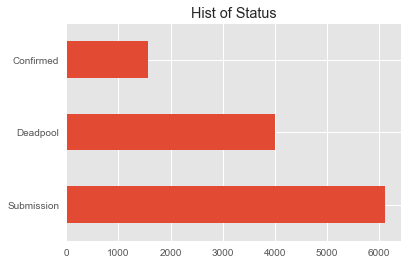

In [48]:
memes.status.value_counts().plot(kind='barh')
plt.title("Hist of Status")
plt.show()

Each meme has one of 3 status:
- Submission - recently added and has not yet gained popularity in the community
- Deadpool - it's dead and nobody cares any longer
- Confirmed - actively used

---



# ML

In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

In [50]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ')])

For modelling purposes, concatenate all the available text fields in one

In [51]:
memes["description"] = memes.tags.fillna('')+' '+memes.about.fillna("")+' '+memes.origin.fillna("")+ " " + memes.spread.fillna("")

In [52]:
memes.description = memes.description.apply(lambda x: x.lower().replace('unknown', ''))

In [53]:
from __future__ import division

In [54]:
X = memes.description[memes.description!="   "]
y = memes.average_views[memes.description!="   "]
status = memes.status[memes.description!="   "]

In [55]:
status = le.fit_transform(status)

For TF-IDF I'll try to use bigrams, and to keep the vocabulary relatively small, let's limit the minimal frequency of word in the document by 0.1%. That means the model will drop words and bigrams that can be found in less than 0.1% of all documents. As a result, the amount of unique words in vocabulary drops from 363K to only 6.4K

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.001, norm='l2')

In [44]:
X_train_vector = tf_vectorizer.fit_transform(X)
X_train_vector.shape

(11154, 6456)

30% of the dataset is reserved for testing

In [45]:
Xtr, Xval, ytr, yval  = train_test_split(X_train_vector, y, test_size=0.30, random_state=42)

Target variable (average views per day), I'll divide into five groups by quantile to shift the task from regression to classification with multiple classes. Simultaneously we are having a naive baseline - if all objects have the same class, the resulting accuracy will be 1/5 = 20%. Another good point - no class disbalance for us!

In [46]:
ytr = pd.qcut(ytr, q=5)

In [47]:
ytr.value_counts()

(76.442, 11084.963]    1562
[0.085, 1.518]         1562
(25.185, 76.442]       1561
(6.795, 25.185]        1561
(1.518, 6.795]         1561
Name: average_views, dtype: int64

Perfect, now we have neat groups for memes:
- totally dead - less than 1 view per day 
- unpopular - 1 to 6 views 
- average - 6 to 24 
- popular - 24 to 74 
- viral - from 74 and higher

For future needs, save the existing intervals 

In [48]:
intervals = ytr.unique().categories.get_values()

Since I cannot perform the same quantile transformation on the test set (groups will not be equal), I need to have a function for test values transformation

In [49]:
def quantile(y):
    for i in range(len(intervals)):
        value = json.loads(intervals[i].replace("(", "["))[1]
        if y<=value:
            return intervals[i]
            break
    return intervals[i]

In [50]:
yval = yval.apply(quantile)

Finally, with the help of `LabelEncoder` prepare target variables for both train and test sets

In [51]:
ytr = le.fit_transform(ytr)
yval = le.fit_transform(yval)

Training two models - logistic regression and random forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [53]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [54]:
def cross_val_predict_proba(estimator, X_train, y_train, skf):
    
    prediction = np.zeros([y_train.shape[0], len(np.unique(y_train))])
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_part, X_test = X_train[train_idx, :], X_train[test_idx,:]
        y_train_part, y_test = y_train[train_idx], y_train[test_idx]
        
        estimator.fit(X_train_part, y_train_part)
        
        prediction[test_idx, :] = estimator.predict_proba(X_test)
        
    return prediction

In [55]:
logit_sgd = SGDClassifier(loss='log', random_state=42)

In [56]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [57]:
logit_sgd_oof_pred = cross_val_predict_proba(logit_sgd, Xtr, ytr, skf)

In [58]:
rf_oof_pred = cross_val_predict_proba(rf, Xtr, ytr, skf)

In [59]:
def get_accuracy_score(predictions, y):
    return round(accuracy_score(map(np.argmax, predictions), y), 3)

In [60]:
get_accuracy_score(logit_sgd_oof_pred, ytr)

0.421

In [61]:
get_accuracy_score(rf_oof_pred, ytr)

0.384

Great, we have noce results here, logistic regression on cross-validation has shown accurace that beats the baseline more than twice (2.3 times to be precise), and forest gave 2 times increase. Now train models on the whole train set to check feature importances

In [62]:
logit_sgd.fit(Xtr, ytr)
logit_sgd_valid_pred = logit_sgd.predict_proba(Xval)

In [63]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

These graphs show top-25 words that most significantly increase the probability of certain popularity class attribution (at least that's what logistic regression thinks)

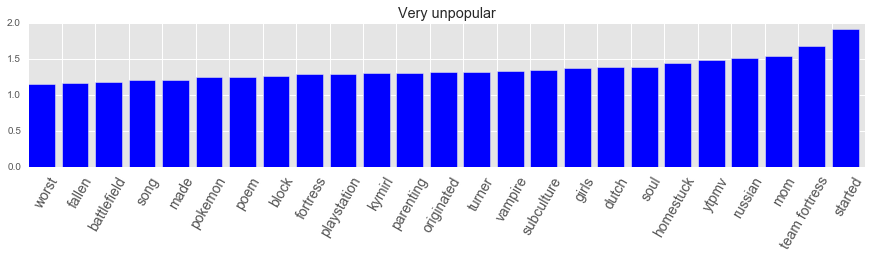

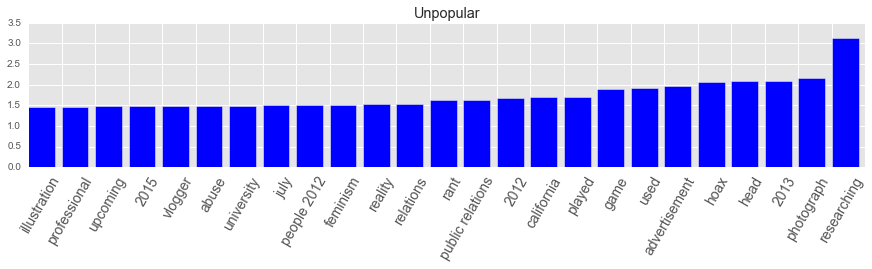

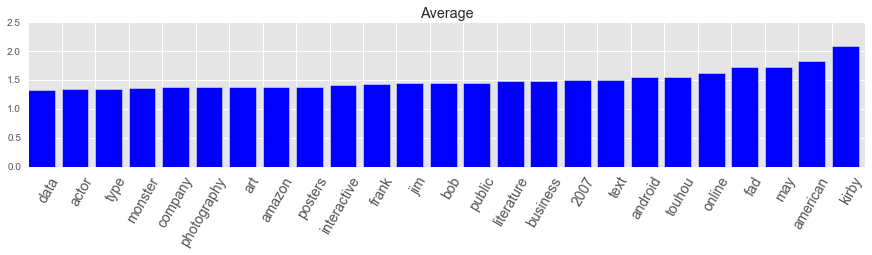

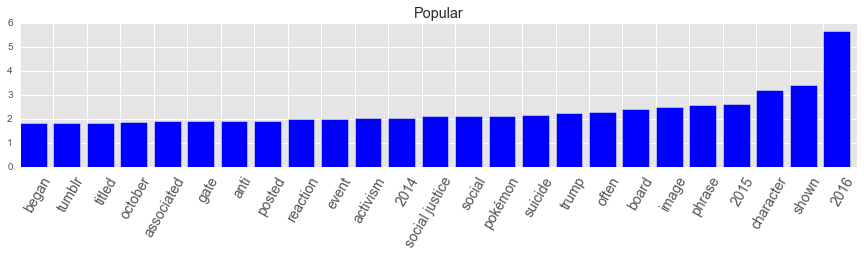

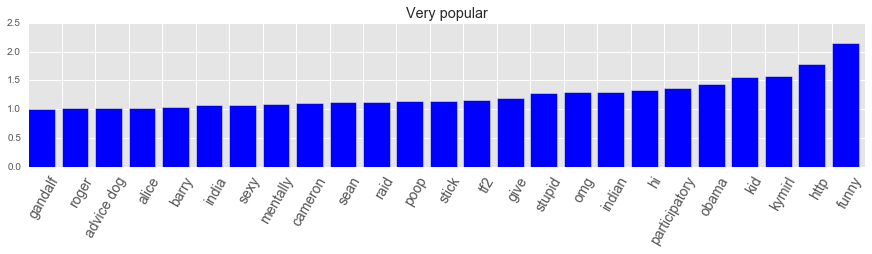

In [64]:
titles = ["Very unpopular", "Unpopular", 'Average', 'Popular', 'Very popular']
for i in range(5):
    visualize_coefficients(logit_sgd.coef_[i,:], tf_vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)

## Some findings

Well, it turned out to be quite fascinating. The most popular memes had words like 'obama', 'islam', 'money' in their text descriptions. That's quite logical - politics, religion and eonomy, nothing can beat those topics, not even kittens. 

Second place (popular) has politics again - we have 'trump', 'politics', 'activism' among the main words. And pokemon, main summer trend!

Average popularity is all about hobbies and animals - 'animal', 'pig', 'dogs', 'health', 'literature', 'videogame', 'fashion', 'american football'. Those are themes that do not get that much of attention usually but are always spoken about nevertheless. 

Unpopular themes have themes like 'researching', 'photograph', 'virtual', 'advertisment', 'professional' and, surprisingly, politics again. Maybe in this group it was mentioned not in the context of the widely discussed news like USA president elections but some more local and moderate. 

Finally, the long forgotten memes - once popular and now practically dead 'team fortress', 'playstation', some words about nationalities, 'frensh', 'dutch' and 'russian' turned out to be the most boring in terms of memes. We can also see pokemon here, written without it's signature style accent, probably, those were some fraud memes and reuploads that rarely gain any attention. 

## Now let's have a closer look at random forest

In [65]:
rf_params_dist_grid = {
    'max_depth': np.arange(5,14, 2),
    'max_features': np.linspace(0.2, 0.5, 3),
    'min_samples_leaf': np.arange(3,10,2)
}
rf_params_fixed = {
    'random_state': 7,
    'n_estimators': 100,
    'n_jobs': -1
    
}

In [66]:
combinations = np.prod([len(i) for i in rf_params_dist_grid.values()])
print('Total number of combinations: {}'.format(combinations))

Total number of combinations: 60


In [67]:
rf_grid = RandomizedSearchCV(
    estimator = RandomForestClassifier(**rf_params_fixed),
    param_distributions = rf_params_dist_grid,
    cv = skf,
    scoring='accuracy',
    n_iter = 10,
    verbose=True
)

In [68]:
%%time
rf_grid.fit(Xtr, ytr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.6min finished


CPU times: user 8min 33s, sys: 9.87 s, total: 8min 42s
Wall time: 4min 40s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': array([ 0.2 ,  0.35,  0.5 ]), 'max_depth': array([ 5,  7,  9, 11, 13]), 'min_samples_leaf': array([3, 5, 7, 9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=True)

In [69]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features=0.20000000000000001,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [70]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):

    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

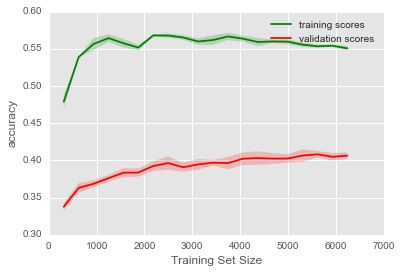

In [71]:
plot_learning_curve(rf_grid.best_estimator_,Xtr, ytr, scoring='accuracy', cv=5)

With a nice pace accuracy on validation is climbing up

In [72]:
print('Accuracy: {}'.format(round(rf_grid.best_score_, 3)))

Accuracy: 0.408


Almost up to logit in quality! Now train on all data with the best parameters

In [73]:
rfc = RandomForestClassifier(random_state=7, oob_score=True, n_estimators=100, n_jobs=-1, **rf_grid.best_params_)
rfc.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features=0.20000000000000001,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=7, verbose=0, warm_start=False)

In [74]:
print('Accuracy: {}'.format(round(rfc.oob_score_, 3)))

Accuracy: 0.409


## Feature importance

In [75]:
names = tf_vectorizer.get_feature_names()
importance = rfc.feature_importances_

feature_weights = pd.DataFrame(importance, index = names, columns = ['importance'])
feature_weights.sort_values(by=['importance'], ascending=False, inplace=True)

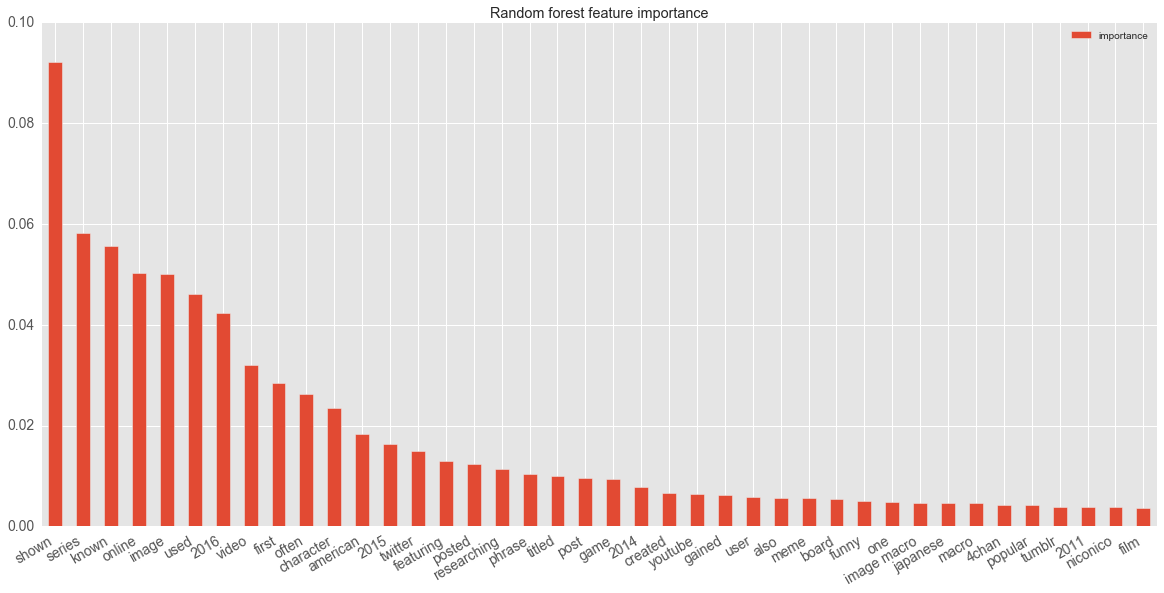

In [76]:
fig, ax = plt.subplots()
feature_weights.head(40).plot(ax=ax,kind = 'bar', figsize=(20, 10), fontsize=14)
fig.autofmt_xdate()
plt.title("Random forest feature importance");

For some reason the most important word is **shown**, it's hard to say without context why; **series** are most probably connected with memes, originated from various tv series; **image** and **video** are among top-10 as well. Presence of year in the description is also important, years from '2011' to '2016' are among top-40 words, could be because of the important events that took place between these years.

Of course, we have main words from out logistic regression here - 'politics', 'funny', 'meme', 'twitter', 'youtube', etc. 

### Now we can have a look at confusion matrix and understand, where models struggle

In [77]:
def plot_confusion(predictions, title):
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array, index = [i for i in titles],
                      columns = [i for i in titles])
    plt.figure(figsize = (7,7))
    sn.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.title(title);

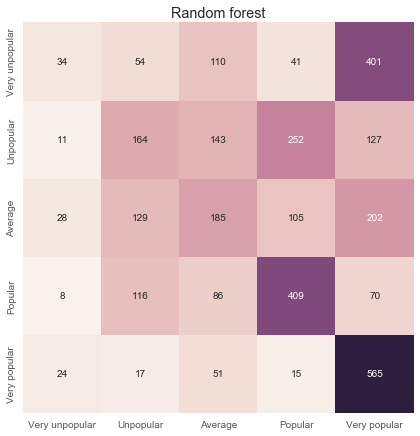

In [78]:
plot_confusion(map(np.argmax, rfc.predict_proba(Xval)), "Random forest")

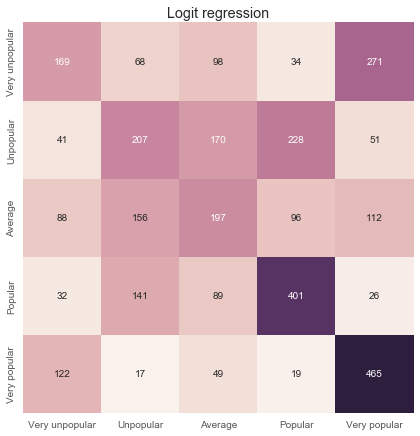

In [79]:
plot_confusion(map(np.argmax, logit_sgd.predict_proba(Xval)), "Logit regression")

It seems like random forest is capable of good differentiating between very popular and [popular categories, while logit has better separation of unpopular and very unpopular memes. That means it's worth trying to blend their predictions

In [80]:
def best_linear_mix(target, pred1, pred2):
    best_acc, best_w1 = 0, 0
    best_pred = pred1
    for w1 in np.linspace(0, 1, 100):
        curr_pred = w1 * pred1 + (1 - w1) * pred2
        curr_acc = accuracy_score(target, np.argmax(curr_pred, axis=1))
        if curr_acc >  best_acc:
            best_acc = curr_acc
            best_pred = curr_pred
            best_w1 = w1
    return best_acc, best_w1

In [81]:
mix_cv_acc, best_logit_weight = best_linear_mix(ytr, logit_sgd_oof_pred, rf_oof_pred)

In [82]:
print('Mix accuracy: {}'.format(round(mix_cv_acc, 3)))
print("Weight of logit in mix: {}".format(round(best_logit_weight, 3)))

Mix accuracy: 0.426
Weight of logit in mix: 0.939


Here is the quality increase, accuracy climbed up by 2%, even though random forest has only 8% of weight in the ensemble.

In [83]:
mix_valid_pred = best_logit_weight * logit_sgd_valid_pred + (1-best_logit_weight) * rfc.predict_proba(Xval)

In [84]:
print('Mix accuracy on validation: {}'.format(get_accuracy_score(mix_valid_pred, yval)))

Mix accuracy on validation: 0.429


Not bad, quality on train and test is almost identical 

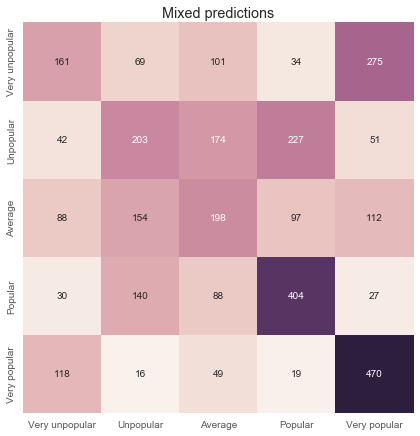

In [85]:
plot_confusion(map(np.argmax, mix_valid_pred), 'Mixed predictions')

Not much, but the diagonal of the matrix now has some more correct predictions

# Conclusions and what was all of that

**Results**
1. Two models are trained as well as their ensemble, which yields accuracy of 0.43, beating the baseline 2.3 times
2. The models have most difficulties with differentiating of Very Unpopular, Unpopular and Average groups. Probably, that is because of the data quality, during pasring some memes, that were added recently, could get a biased popularity estimate (few days passed since their creation). It can be fixed by limiting the dataset by date so that each meme has a least one month of history, for example.
3. Logistic regression allowed us to find some logical groups of words with common themes 

**But why?**
1. For research purposes
2. Of course, meme popularity predictions are hard to monetize but predicting the virality of your advertisement - that's where we're talking business. 

**What else can be done**
1. More complex models and metadata. We still have lot's of features to be explored and added to the mosel, starting from dates and going as far as topic modelling over memes, why not.  
2. Neural networks, of course. And lots of layers. And then some more. Dataset can be enriched with the most important meme part - the meme itself. Working with pictures can open so many opportunities. Besides, most memes are created with the help of templates and generators, so we can try to claster groups of pictures by their templates and use it for predictions. 
3. Finally, the most interesting part - our own neural network memegenerator. Having template examples, text descriptions and other cool stuff we can try to synthesize meme and its text. Oh boy, oh boy! 

To be continued...

**sorry for a long post, here is a research potato for you**
![](http://www.cosplayisland.co.uk/files/costumes/855/41850/5643874030_530d7eba22.jpg)